# Turning Raw User Data Into Web Analytics

In this notebook I take raw user data from an app and use Python to investigate how the app is performing. The app is a creative design platform where users can build, draw or learn. I start by preparing the data for analysis before writing code to compute the following metrics.

* Installation Date.
* Number of Users.
* Monthly Active Users.
* Retention Rate.
* Time in Application.
* Content Type.

There are three versions of the app, so we would like to see if newer versions of the app have increased customer engagement.

---

## Data Preparation

Start by importing the libraries required for this test.

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.dates import date2num
import seaborn as sns

Create two dataframes for the *users* and *events* data.

In [2]:
users = pd.read_csv('data/users.csv')
users.head()

,user_id,install_date,app_version
0,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1
1,0020cb805d63f036ad2c22dd8e76e368,2016-01-16,Unknown
2,002a9119a4b3dfb05e0159eee40576b6,2015-12-29,v2
3,0038c5018fb1c0c9d0dea9181a5a0834,2015-06-06,v2
4,00448cf7dd8ad9e8a57fdcfa262a4438,2015-12-22,v2


We see that the *users* data contains the unique user id, date of download and the version that was downloaded.

In [3]:
events = pd.read_csv('data/events.csv')
events.head()

,user_id,user_session_id,event_timestamp,app,time_seconds
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,67
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,277
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,779
3,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 02:17:00,build,145
4,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 03:26:03,draw,319


The *events* data contains the unique user id once again, and a user session ID. This is a stamp that is created each time a user triggers an event (e.g. opening a new page) when using the app.

There is also a timestamp, what type of action was performed (build, draw or learn) and the time spent in that feature.

These two dataframes, *users* and *events*, form the basis of our analysis.

---

## Data Preprocessing

To help with data manipulation later, we convert the object columns to string and datetime formats as applicable.

In [4]:
users['user_id'] = users['user_id'].astype(str)
users['install_date'] = pd.to_datetime(users['install_date'])
users['app_version'] = users['app_version'].astype(str)

In [5]:
events['user_id'] = events['user_id'].astype(str)
events['user_session_id'] = events['user_session_id'].astype(str)
events['event_timestamp'] = pd.to_datetime(events['event_timestamp'])
events['app'] = events['app'].astype(str)

In [6]:
# 'time_seconds' is already an Integer.
events['time_seconds'].dtype

dtype('int64')

Now we merge the two dataframes to create a table that holds all of our data. This is like a join in SQL. We have the following four options with this method.

* Left - use only keys from the left dataframe (similar to SQL left outer join).
* Right - use only keys from the right dataframe (similar to SQL right outer join).
* Outer - use union of keys from both dataframes (similar to SQL full outer join).
* Inner - use intersection of keys from both dataframes (similar to SQL inner join).

Here I will use an inner join.

In [7]:
big_table = pd.merge(users, events, how = 'inner', on = 'user_id')
big_table.head()

,user_id,install_date,app_version,user_session_id,event_timestamp,app,time_seconds
0,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,d1fdd0d46f2aba7d216c3e1bfeabf0d8,2015-05-04 18:06:54,build,1469
1,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,7692f450607a0a518d564c0a1a15b805,2015-06-18 15:39:50,draw,220
2,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,f3501a97f8caae8e93764ff7a0a75a76,2015-06-20 10:59:22,draw,682
3,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,ce644b02c1d0ab9589ccfa5031a40c98,2016-01-31 18:44:01,draw,195
4,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,b6b9813985db55a4ccd08f9bc8cd6b4e,2016-01-31 19:27:12,build,261


Later on I will be performing some analysis on what time of the day the app is being used. I'll write a couple of functions to address that.

In [8]:
# Create a function to extract the hour from the 'event_timestamp'.
def get_hour(timestamp):
    return timestamp.hour

In [9]:
# Create a function to get the time of day from the hour.
def get_time_of_day(h):
    if (h >= 6) & (h < 9):
        return 'early morning'
    elif (h >= 9) & (h < 12): 
        return 'late morning'
    elif (h >= 12) & (h < 14): 
        return 'lunchtime'
    elif (h >= 14) & (h < 17): 
        return 'afternoon'
    elif (h >= 17) & (h < 19): 
        return 'early evening'
    elif (h >= 19) & (h < 22): 
        return 'late evening'
    else:
        return 'night'

In [10]:
# Apply the above two functions to create a 'time_of_day' column.
big_table['time_of_day'] = big_table['event_timestamp'].apply(get_hour).apply(get_time_of_day)
big_table.head(2)

,user_id,install_date,app_version,user_session_id,event_timestamp,app,time_seconds,time_of_day
0,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,d1fdd0d46f2aba7d216c3e1bfeabf0d8,2015-05-04 18:06:54,build,1469,early evening
1,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,7692f450607a0a518d564c0a1a15b805,2015-06-18 15:39:50,draw,220,afternoon


In this task I will see how the KPIs compare for each version of the app. In order to facilitate this I'll create three new dataframes for versions 1, 2 and 3.

In [11]:
v1 = big_table[big_table['app_version'] == 'v1']
v2 = big_table[big_table['app_version'] == 'v2']
v3 = big_table[big_table['app_version'] == 'v3']

Ok great, we now have a central dataframe with all of the joined data and from this three separate dataframes for each of the app versions. We can now start to perform the analysis.

---

## Installation Date

Just to start us off, let's see when people downloaded the app. As the table below shows, the top ten days for downloading were always during the week commencing at Christmas.

In [12]:
pd.DataFrame(pd.value_counts(users.install_date)).head(10)

,install_date
2015-12-25,334
2014-12-25,172
2015-12-26,133
2015-12-27,125
2015-12-28,80
2014-12-26,80
2015-12-29,59
2016-01-02,47
2015-12-30,47
2015-12-31,43


The chart below shows significant spikes at Christmas time relative to the rest of the year.

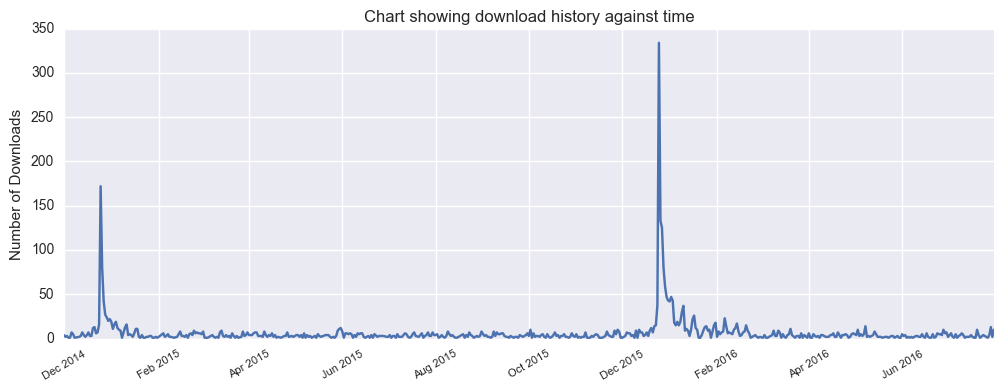

In [13]:
users_by_date = pd.DataFrame(pd.value_counts(users.install_date)).sort_index()

plt.figure(figsize = (12, 4))
plt.plot(users_by_date.index, users_by_date['install_date'])
plt.xticks(fontsize = 8, rotation = 30)
plt.ylabel('Number of Downloads')
plt.title('Chart showing download history against time')
plt.show()

---

## Number of Users

Let's investigate the *users* data.

In [14]:
len(users.user_id.unique())

3900

We have 3,900 unique users. How does that break down by app version?

In [15]:
pd.value_counts(users.app_version)

v2         2596
v1         1116
v3          113
Unknown      75
Name: app_version, dtype: int64

In [16]:
print 'v1 share of downloads', 1116 / 3900
print 'v2 share of downloads', 2596 / 3900
print 'v3 share of downloads', 113 / 3900
print 'Unknown share of downloads', 75 / 3900

v1 share of downloads 0.286153846154
v2 share of downloads 0.665641025641
v3 share of downloads 0.0289743589744
Unknown share of downloads 0.0192307692308


We see that 66% of users have downloaded v2 with 29% using v1. Only 3% use v3 with 2% undefined.

However, not all the people who downloaded the app went on to use it. We see that of 3,900 people to make a download, only 2,243 have triggered an event.

In [17]:
print len(events.user_id.unique()), 'unique users by event'

2243 unique users by event


In [18]:
2243 / 3900

0.5751282051282052

So only 58% of people who download go on to be users.

How do the number of users vary by the app version?

In [19]:
print len(v1.user_id.unique()), 'unique users of v1'
print len(v2.user_id.unique()), 'unique users of v2'
print len(v3.user_id.unique()), 'unique users of v3'

218 unique users of v1
1940 unique users of v2
85 unique users of v3


Of the people who downloaded the app, which version has the highest usage yield?

In [20]:
print 'v1 yield', 218/1116
print 'v2 yield', 1940/2596
print 'v3 yield', 85/113

v1 yield 0.195340501792
v2 yield 0.747303543914
v3 yield 0.752212389381


So we see that versions 2 and 3 have very similar usage rates - around three quarters of users who downloaded these versions went on to use them.

---

## Monthly Active Users

Before we begin, I need to specify what an active user is. I will input an *active threshold* which is the number of visits per month that a user must make to qualify as being 'active'. This is arbitrary and can be changed.

In [21]:
# Input the active threshold here. It can be anything you choose.

active_threshold = 10

Get the earliest and latest timestamps from the data, then create a list of months.

In [22]:
print 'Earliest data point', big_table['event_timestamp'].min()
print 'Latest data point', big_table['event_timestamp'].max()

Earliest data point 2015-03-07 00:39:33
Latest data point 2016-10-05 16:57:16


In [23]:
dates = ['2015-03-01',
         '2015-04-01',
         '2015-05-01',
         '2015-06-01',
         '2015-07-01',
         '2015-08-01',
         '2015-09-01',
         '2015-10-01',
         '2015-11-01',
         '2015-12-01',
         '2016-01-01',
         '2016-02-01',
         '2016-03-01',
         '2016-04-01',
         '2016-05-01',
         '2016-06-01',
         '2016-07-01',
         '2016-08-01',
         '2016-09-01',
         '2016-10-01',
         '2016-11-01']

In [24]:
# this deals with deprecations, copy warnings etc.
import warnings
warnings.filterwarnings('ignore')

Here I extract the monthly active user data by using a *for* loop with an *and* statement. I loop through the Version 1 dataframe created earlier and extract the rows within the endpoints for the month in question.

Then I use the *groupby* function to create a column with user visits before filtering with the *active threshold* defined above.

In [25]:
# Monthly Active Users for Version 1.
v1_mau = []
for i in range(0, len(dates)-1):
    month = v1[(v1['event_timestamp'] >= dates[i]) & (v1['event_timestamp'] < dates[i+1])]
    month['freq'] = month.groupby('user_id')['user_id'].transform('count')
    month = month[month['freq'] >= active_threshold]
    n = len(month.user_id.unique())
    v1_mau.append(n)
print v1_mau

[0, 2, 5, 4, 1, 4, 2, 5, 2, 3, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0]


In [26]:
# Monthly Active Users for Version 2.
v2_mau = []
for i in range(0, len(dates)-1):
    month = v2[(v2['event_timestamp'] >= dates[i]) & (v2['event_timestamp'] < dates[i+1])]
    month['freq'] = month.groupby('user_id')['user_id'].transform('count')
    month = month[month['freq'] >= active_threshold]
    n = len(month.user_id.unique())
    v2_mau.append(n)
print v2_mau

[0, 0, 2, 11, 14, 13, 17, 10, 16, 199, 179, 69, 43, 42, 38, 21, 19, 8, 10, 0]


In [27]:
# Monthly Active Users for Version 3.
v3_mau = []
for i in range(0, len(dates)-1):
    month = v3[(v3['event_timestamp'] >= dates[i]) & (v3['event_timestamp'] < dates[i+1])]
    month['freq'] = month.groupby('user_id')['user_id'].transform('count')
    month = month[month['freq'] >= active_threshold]
    n = len(month.user_id.unique())
    v3_mau.append(n)
print v3_mau

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 14, 3, 1, 0]


Create a dataframe of the numbers just generated.

In [28]:
my_data = {'version_1': v1_mau, 'version_2': v2_mau, 'version_3': v3_mau}
date_labels = pd.to_datetime(dates[0:20])
my_df = pd.DataFrame(data = my_data, index = date_labels)
my_df

,version_1,version_2,version_3
2015-03-01,0,0,0
2015-04-01,2,0,0
2015-05-01,5,2,0
2015-06-01,4,11,0
2015-07-01,1,14,0
2015-08-01,4,13,0
2015-09-01,2,17,0
2015-10-01,5,10,0
2015-11-01,2,16,0
2015-12-01,3,199,0


Now plot the data.

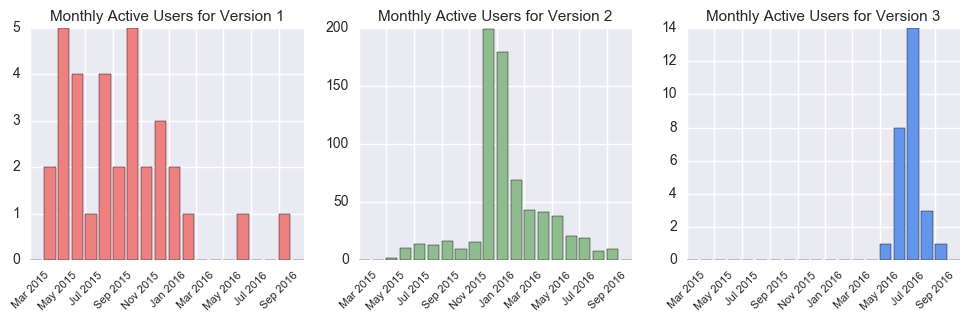

Users defined as active if they make at least 10 visits per month.


In [29]:
plt.figure(figsize = (12,3))

plt.subplot(1,3,1)
plt.bar(date_labels, v1_mau, 25, label = 'Version 1', color = 'lightcoral')
plt.title('Monthly Active Users for Version 1', size = 11)
plt.xticks(size = 8, rotation = 45)

plt.subplot(1,3,2)
plt.bar(date_labels, v2_mau, 25, label = 'Version 2', color = 'darkseagreen')
plt.title('Monthly Active Users for Version 2', size = 11)
plt.xticks(size = 8, rotation = 45)

plt.subplot(1,3,3)
plt.bar(date_labels, v3_mau, 25, label = 'Version 3', color = 'cornflowerblue')
plt.title('Monthly Active Users for Version 3', size = 11)
plt.xticks(size = 8, rotation = 45)

plt.show()

print 'Users defined as active if they make at least', active_threshold, 'visits per month.'

In absolute terms, we see how version 2 takes the lion's share of active users, reaching 199 in December 2015.

We saw earlier how, of the 2,243 downloaders who went on to use the app, 218 were on version 1 and 1,940 were on version 2. This is a ratio of 8.9.

So, even on a proportional basis, we see that version 2 has a far greater active user base than version 1, especially at peak times.

Version 3 certainly punches above its weight though. It only has 85 active downloads but performs well in the summer months after launch. On a like for like basis it appears to outperform previous versions.

To visualise these 'proportional' usages see the chart below. It shows active users on a normalised basis.

In [30]:
v1_mau_norm = []
for i in v1_mau:
    v1_mau_norm.append(i/218)
    
v2_mau_norm = []
for i in v2_mau:
    v2_mau_norm.append(i/1940)
    
v3_mau_norm = []
for i in v3_mau:
    v3_mau_norm.append(i/85)

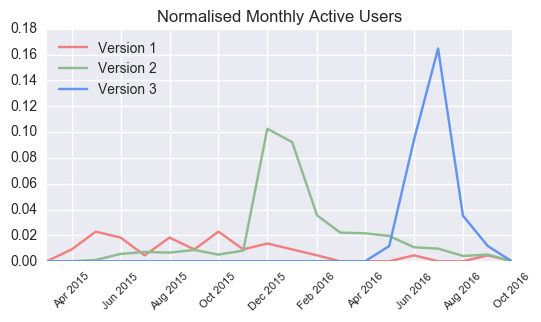

In [31]:
plt.figure(figsize = (6,3))
plt.plot(date_labels, v1_mau_norm, label = 'Version 1', color = 'lightcoral')
plt.plot(date_labels, v2_mau_norm, label = 'Version 2', color = 'darkseagreen')
plt.plot(date_labels, v3_mau_norm, label = 'Version 3', color = 'cornflowerblue')
plt.xticks(size = 8, rotation = 45)
plt.legend(loc = 'top left')
plt.title('Normalised Monthly Active Users')
plt.show()

The chart shows that the active usage for the app increases with each version released. Very encouraging! However, we must be mindful that v3 does not have many users so more data is required to back this up.

---

## Retention Rate

With Retention Rates we are looking to see if a user who is active in any particular month is also active the month after (or three months after, six months after and so on).

Define retention lag length below (in months).

In [32]:
# Set the retention timeframe (in months) here.

lag = 1

In [33]:
# Retention Rates for Version 1.
v1_rr = []
for i in range(0, len(dates)-2*lag):
    period_1 = v1[(v1['event_timestamp'] >= dates[i]) & (v1['event_timestamp'] < dates[i+lag])]
    period_2 = v1[(v1['event_timestamp'] >= dates[i+lag]) & (v1['event_timestamp'] < dates[i+2*lag])]
    retentions = len(set([i for i in period_2.user_id.tolist() if i in period_1.user_id.tolist()]))
    v1_rr.append(retentions)
print v1_rr

[14, 24, 14, 12, 11, 8, 11, 13, 7, 5, 5, 4, 4, 2, 2, 3, 3, 2, 0]


In [34]:
# Retention Rates for Version 2.
v2_rr = []
for i in range(0, len(dates)-2*lag):
    period_1 = v2[(v2['event_timestamp'] >= dates[i]) & (v2['event_timestamp'] < dates[i+lag])]
    period_2 = v2[(v2['event_timestamp'] >= dates[i+lag]) & (v2['event_timestamp'] < dates[i+2*lag])]
    retentions = len(set([i for i in period_2.user_id.tolist() if i in period_1.user_id.tolist()]))
    v2_rr.append(retentions)
print v2_rr

[0, 0, 18, 16, 26, 24, 32, 28, 43, 393, 266, 167, 135, 118, 86, 74, 55, 34, 10]


In [35]:
# Retention Rates for Version 3.
v3_rr = []
for i in range(0, len(dates)-2*lag):
    period_1 = v3[(v3['event_timestamp'] >= dates[i]) & (v3['event_timestamp'] < dates[i+lag])]
    period_2 = v3[(v3['event_timestamp'] >= dates[i+lag]) & (v3['event_timestamp'] < dates[i+2*lag])]
    retentions = len(set([i for i in period_2.user_id.tolist() if i in period_1.user_id.tolist()]))
    v3_rr.append(retentions)
print v3_rr

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 11, 21, 9, 2]


Create a dataframe to tabulate the data.

In [36]:
my_data_2 = {'version_1': v1_rr, 'version_2': v2_rr, 'version_3': v3_rr}
date_labels = pd.to_datetime(dates[2*lag:21])
date_labels = [d - timedelta(days = 1) for d in date_labels]
my_df_2 = pd.DataFrame(data = my_data_2, index = date_labels)
my_df_2

,version_1,version_2,version_3
2015-04-30,14,0,0
2015-05-31,24,0,0
2015-06-30,14,18,0
2015-07-31,12,16,0
2015-08-31,11,26,0
2015-09-30,8,24,0
2015-10-31,11,32,0
2015-11-30,13,28,0
2015-12-31,7,43,0
2016-01-31,5,393,0


Now plot the data.

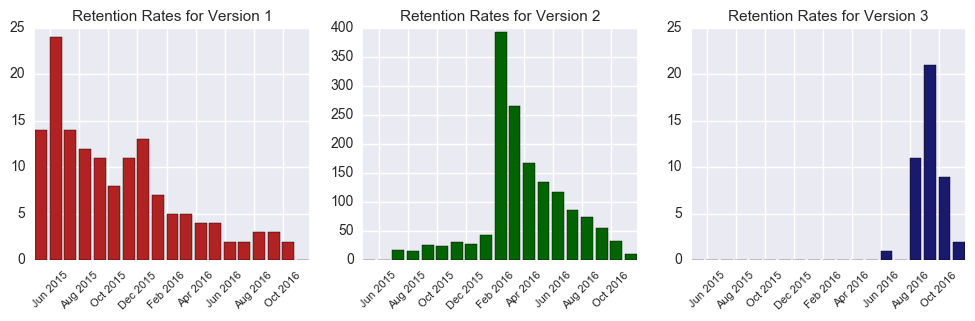

Period evaluated over 1 month.


In [37]:
plt.figure(figsize = (12,3))

plt.subplot(1,3,1)
plt.bar(date_labels, v1_rr, 25, label = 'Version 1', color = 'firebrick')
plt.title('Retention Rates for Version 1', size = 11)
plt.xticks(size = 8, rotation = 45)

plt.subplot(1,3,2)
plt.bar(date_labels, v2_rr, 25, label = 'Version 2', color = 'darkgreen')
plt.title('Retention Rates for Version 2', size = 11)
plt.xticks(size = 8, rotation = 45)

plt.subplot(1,3,3)
plt.bar(date_labels, v3_rr, 25, label = 'Version 3', color = 'midnightblue')
plt.title('Retention Rates for Version 3', size = 11)
plt.xticks(size = 8, rotation = 45)

plt.show()

print 'Period evaluated over', lag, 'month.'

We see here retention rates using a rolling 1 month window. With version 1 we see that retention rates are falling over the period in question. With version 2 however, there is a large spike in January 2016 with attenuation downwards after that. Version 3 does show a more positive result, with retention rates actually increasing, albeit on the back of a relatively short product lifecycle so far.

Now let's look at the normalised data relative to active downloads.

In [38]:
v1_rr_norm = []
for i in v1_rr:
    v1_rr_norm.append(i/218)
    
v2_rr_norm = []
for i in v2_rr:
    v2_rr_norm.append(i/1940)
    
v3_rr_norm = []
for i in v3_rr:
    v3_rr_norm.append(i/85)

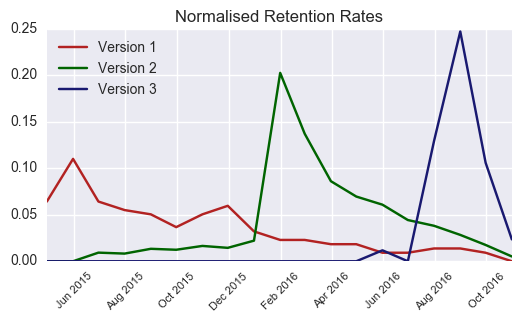

In [39]:
plt.figure(figsize = (6,3))
plt.plot(date_labels, v1_rr_norm, label = 'Version 1', color = 'firebrick')
plt.plot(date_labels, v2_rr_norm, label = 'Version 2', color = 'darkgreen')
plt.plot(date_labels, v3_rr_norm, label = 'Version 3', color = 'midnightblue')
plt.xticks(size = 8, rotation = 45)
plt.legend(loc = 'top left')
plt.title('Normalised Retention Rates')
plt.show()

We see that Version 3 has higher Retention Rates than previous versions, with a quarter of users from July 2016 revisiting the app the following month.

---

## Time in Application

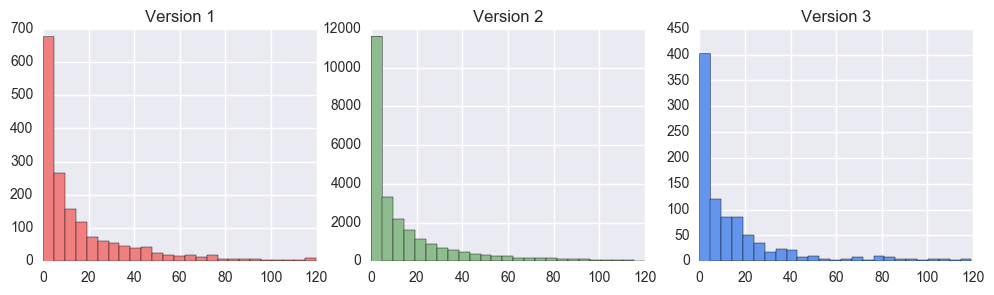

In [40]:
plt.figure(figsize = (12,3))

plt.subplot(1,3,1)
plt.hist(v1.time_seconds/60, bins = 25, color = 'lightcoral')
plt.title('Version 1')

plt.subplot(1,3,2)
plt.hist(v2.time_seconds/60, bins = 25, color = 'darkseagreen')
plt.title('Version 2')

plt.subplot(1,3,3)
plt.hist(v3.time_seconds/60, bins = 25, color = 'cornflowerblue')
plt.title('Version 3')

plt.show()

These histograms show a fairly similar profile for each of the three versions when we look at time in application. The bars represent around 5 minutes each. We can see that many users drop off in the first five minutes.

On version 3 however, we do see a slight stabilisation between 10 and 20 minutes which we don't get for the previous versions. This would suggest that the new version has improved retention during this time span.

Let's now see how the *Time in Application* changes depending on the time of day.

In [41]:
big_table.groupby(['time_of_day'])['time_seconds'].mean()/60

time_of_day
afternoon        16.346736
early evening    15.175180
early morning    17.168561
late evening     14.538350
late morning     16.362688
lunchtime        16.906656
night            14.048636
Name: time_seconds, dtype: float64

Here we see that the early morning and lunchtime periods are when users spend the longest on the app, typically 17 minutes. People spend less time after 7pm, averaging just over 14 minutes.

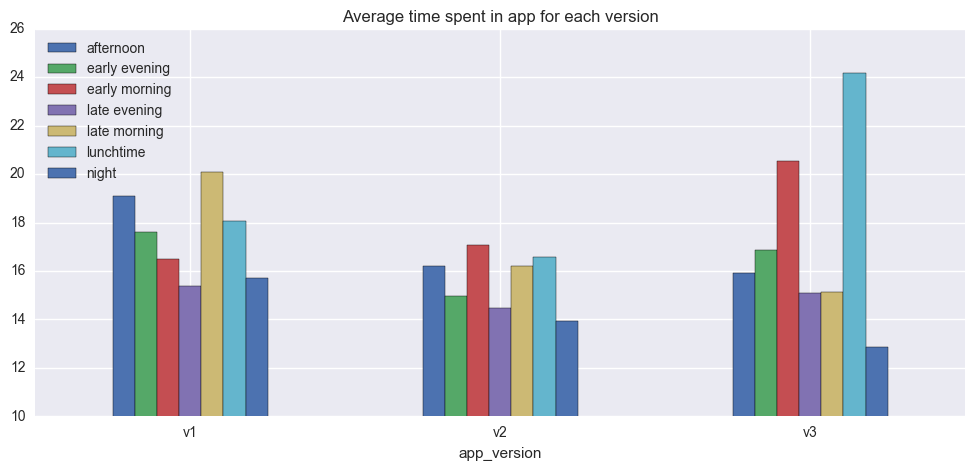

In [42]:
(big_table.groupby(['app_version', 'time_of_day'])['time_seconds'].mean()/60).unstack().plot(kind = 'bar', figsize = (12,5))
plt.xticks(rotation = 0)
plt.ylim(10,26)
plt.legend(loc = 'best')
plt.title('Average time spent in app for each version')
plt.show()

Here we see that late morning is becoming less popular with each version of the app, but version 3 users spend longest on the app in the early morning and at lunchtime.

---

## Content Type

Ok, so we looked earlier at downloads by app version. What about the content that users are looking at?

In [43]:
events.app.count()

27726

We have 27,726 events to look at.

In [44]:
pd.value_counts(events.app)

build    15299
draw      8021
learn     4406
Name: app, dtype: int64

In [45]:
print 'Build share of usage', 15299 / events.app.count()
print 'Draw share of usage', 8021 / events.app.count()
print 'Learn share of usage', 4406 / events.app.count()

Build share of usage 0.551792541297
Draw share of usage 0.289295246339
Learn share of usage 0.158912212364


Of all the visits to the site
* 55% of users are building.
* 29% of users are drawing.
* 16% of users are learning.

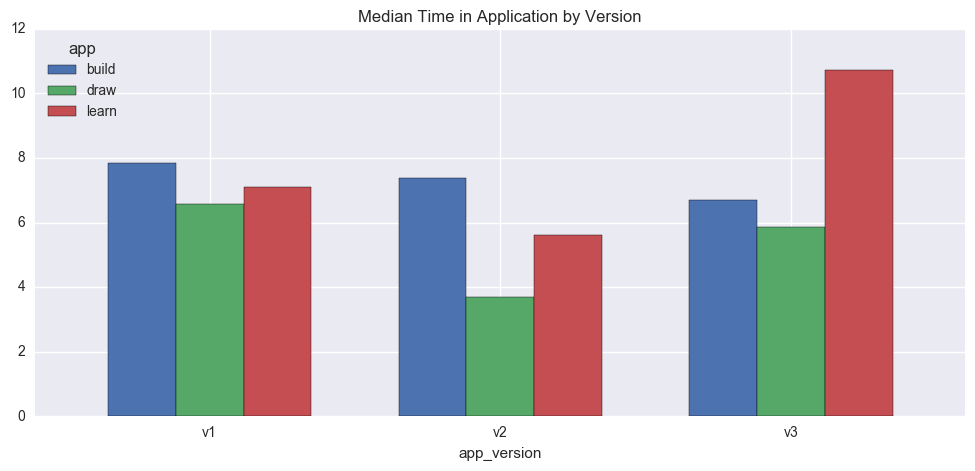

In [46]:
chart = (big_table.groupby(['app_version', 'app'])['time_seconds'].median()/60).unstack()
chart.plot(kind = 'bar', width = 0.7, figsize = (12,5))
plt.xticks(rotation = 0)
plt.title('Median Time in Application by Version')
plt.show()

In the above data I have taken the median time in application for each version, grouped by the activity type. We see that for building, the time in application falls with each new version, albeit not dramatically. Drawing falls off for version 2 but recovers somewhat with version 3. Learning, however, falls for version 2 but sees a significant spike upwards for version 3. This suggests that even though people are spending less time building with the latest version, they are engaging more with understanding the new app.

---

## Conclusions

* The vast majority of downloads occur around the Christmas period. Of the people who downloaded versions 2 and 3, around three quarters went on to use it.

* Even though version 3 is still quite new, it has a higher normalised active user rate than its predecessors. Retention rates seemed to improve too, albeit on the back of limited data.

* The first five minutes is key in retaining users. Many users drop off in this period, although version 3 did well at stabilising shutdowns between 10 and 20 minutes. Users spend longer on the app in the early morning and at lunchtime.

* The newest version of the app doesn't necessarily increase building or drawing time, but it does show a significant leap in users wanting to learn about the app.